# Analyze Deformed Tadpole Output from Trex
This notebook takes output data from the [Trex](https://github.com/mooch443/trex) compute vision tool and runs exploratory data analysis on the information provided for each tadpole.  Tadpole footage comes from [Levin lab](https://ase.tufts.edu/biology/labs/levin/).

### Set Parameters for Analysis

In [1]:
TREX_OUTPUT_DATA_PATH = "/Users/jstremme/Videos/data/"
COLLISION_THRESHOLD = 0.1

### Install Required Libraries

In [2]:
!pip install -q numpy
!pip install -q pandas
!pip install -q matplotlib
!pip install -q ray

### Import Installed Libraries

In [3]:
# Built-In
import os
import glob
import time
import random

# External
import ray
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Print External Library Versions for Reproducibility

In [4]:
np.__version__

'1.19.5'

In [5]:
pd.__version__

'1.3.1'

In [6]:
mpl.__version__

'3.4.2'

In [7]:
ray.__version__

'1.6.0'

### View Tadpole Data Files

In [8]:
all_tadpole_data_files = glob.glob(TREX_OUTPUT_DATA_PATH + '*.npz')

In [9]:
all_tadpole_data_files

['/Users/jstremme/Videos/data/black-pebble_tadpole12.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole13.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole11.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole10.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole9.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole28.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole14.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole15.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole29.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole8.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole17.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole16.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole6.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole27.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole26.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole7.npz',
 '/Users/jstremme/Videos/data/black-pebble_tadpole5.npz',
 '

### Show Available Tadpole Data for a Random Tadpole
The `sample_tadpole_data` object contains information available for a single tadpole tracked by Trex.

In [10]:
sample_tadpole_data_files = random.choice(all_tadpole_data_files)
sample_tadpole_data = np.load(sample_tadpole_data_files)

In [11]:
sample_tadpole_data.files

['segment_length',
 'normalized_midline',
 'missing',
 'midline_y',
 'Y',
 'midline_x',
 'ANGULAR_A#centroid',
 'SPEED#smooth#wcentroid',
 'X',
 'MIDLINE_OFFSET',
 'midline_length',
 'VY',
 'time',
 'num_pixels',
 'VX',
 'BORDER_DISTANCE#pcentroid',
 'SPEED#wcentroid',
 'AY',
 'frame',
 'SPEED#pcentroid',
 'Y#wcentroid',
 'X#wcentroid',
 'AX',
 'SPEED',
 'ANGULAR_V#centroid',
 'ANGLE',
 'ACCELERATION#wcentroid',
 'timestamp',
 'ACCELERATION#pcentroid',
 'frame_segments',
 'segment_vxys']

### View Sample Tadpole Positions at Each Timestamp

In [12]:
sample_position_df = pd.DataFrame({
    'timestamp': sample_tadpole_data['timestamp'],
    'X': sample_tadpole_data['X'],
    'Y': sample_tadpole_data['Y']
})

In [13]:
display(sample_position_df.sample(n=10))

timestamp          X          Y
5374   1.853103e+08        inf        inf
23640  8.151724e+08  16.372480  11.984918
36526  1.259517e+09  13.013436  12.688366
11765  4.056897e+08  16.312929  12.517247
16095  5.550000e+08        inf        inf
17674  6.094483e+08  15.076272   3.732901
35045  1.208448e+09  18.487078  10.642115
18083  6.235517e+08   9.895306   5.577206
24811  8.555517e+08  12.809957   3.748890
13909  4.796207e+08        inf        inf

### Review and Drop Frames with Infinite X, Y Values

In [14]:
sample_position_df.shape

(37949, 3)

In [15]:
sample_position_df.replace([np.inf, -np.inf], np.nan, inplace=True)
sample_position_df.dropna(inplace=True)

In [16]:
sample_position_df.shape

(30593, 3)

### Plot Coordinates in Time for Non-Missing Frames
We could plot all tadpoles with different colors on the same 3D graph, maybe with mpld3 or another tool that allows for close inspection.

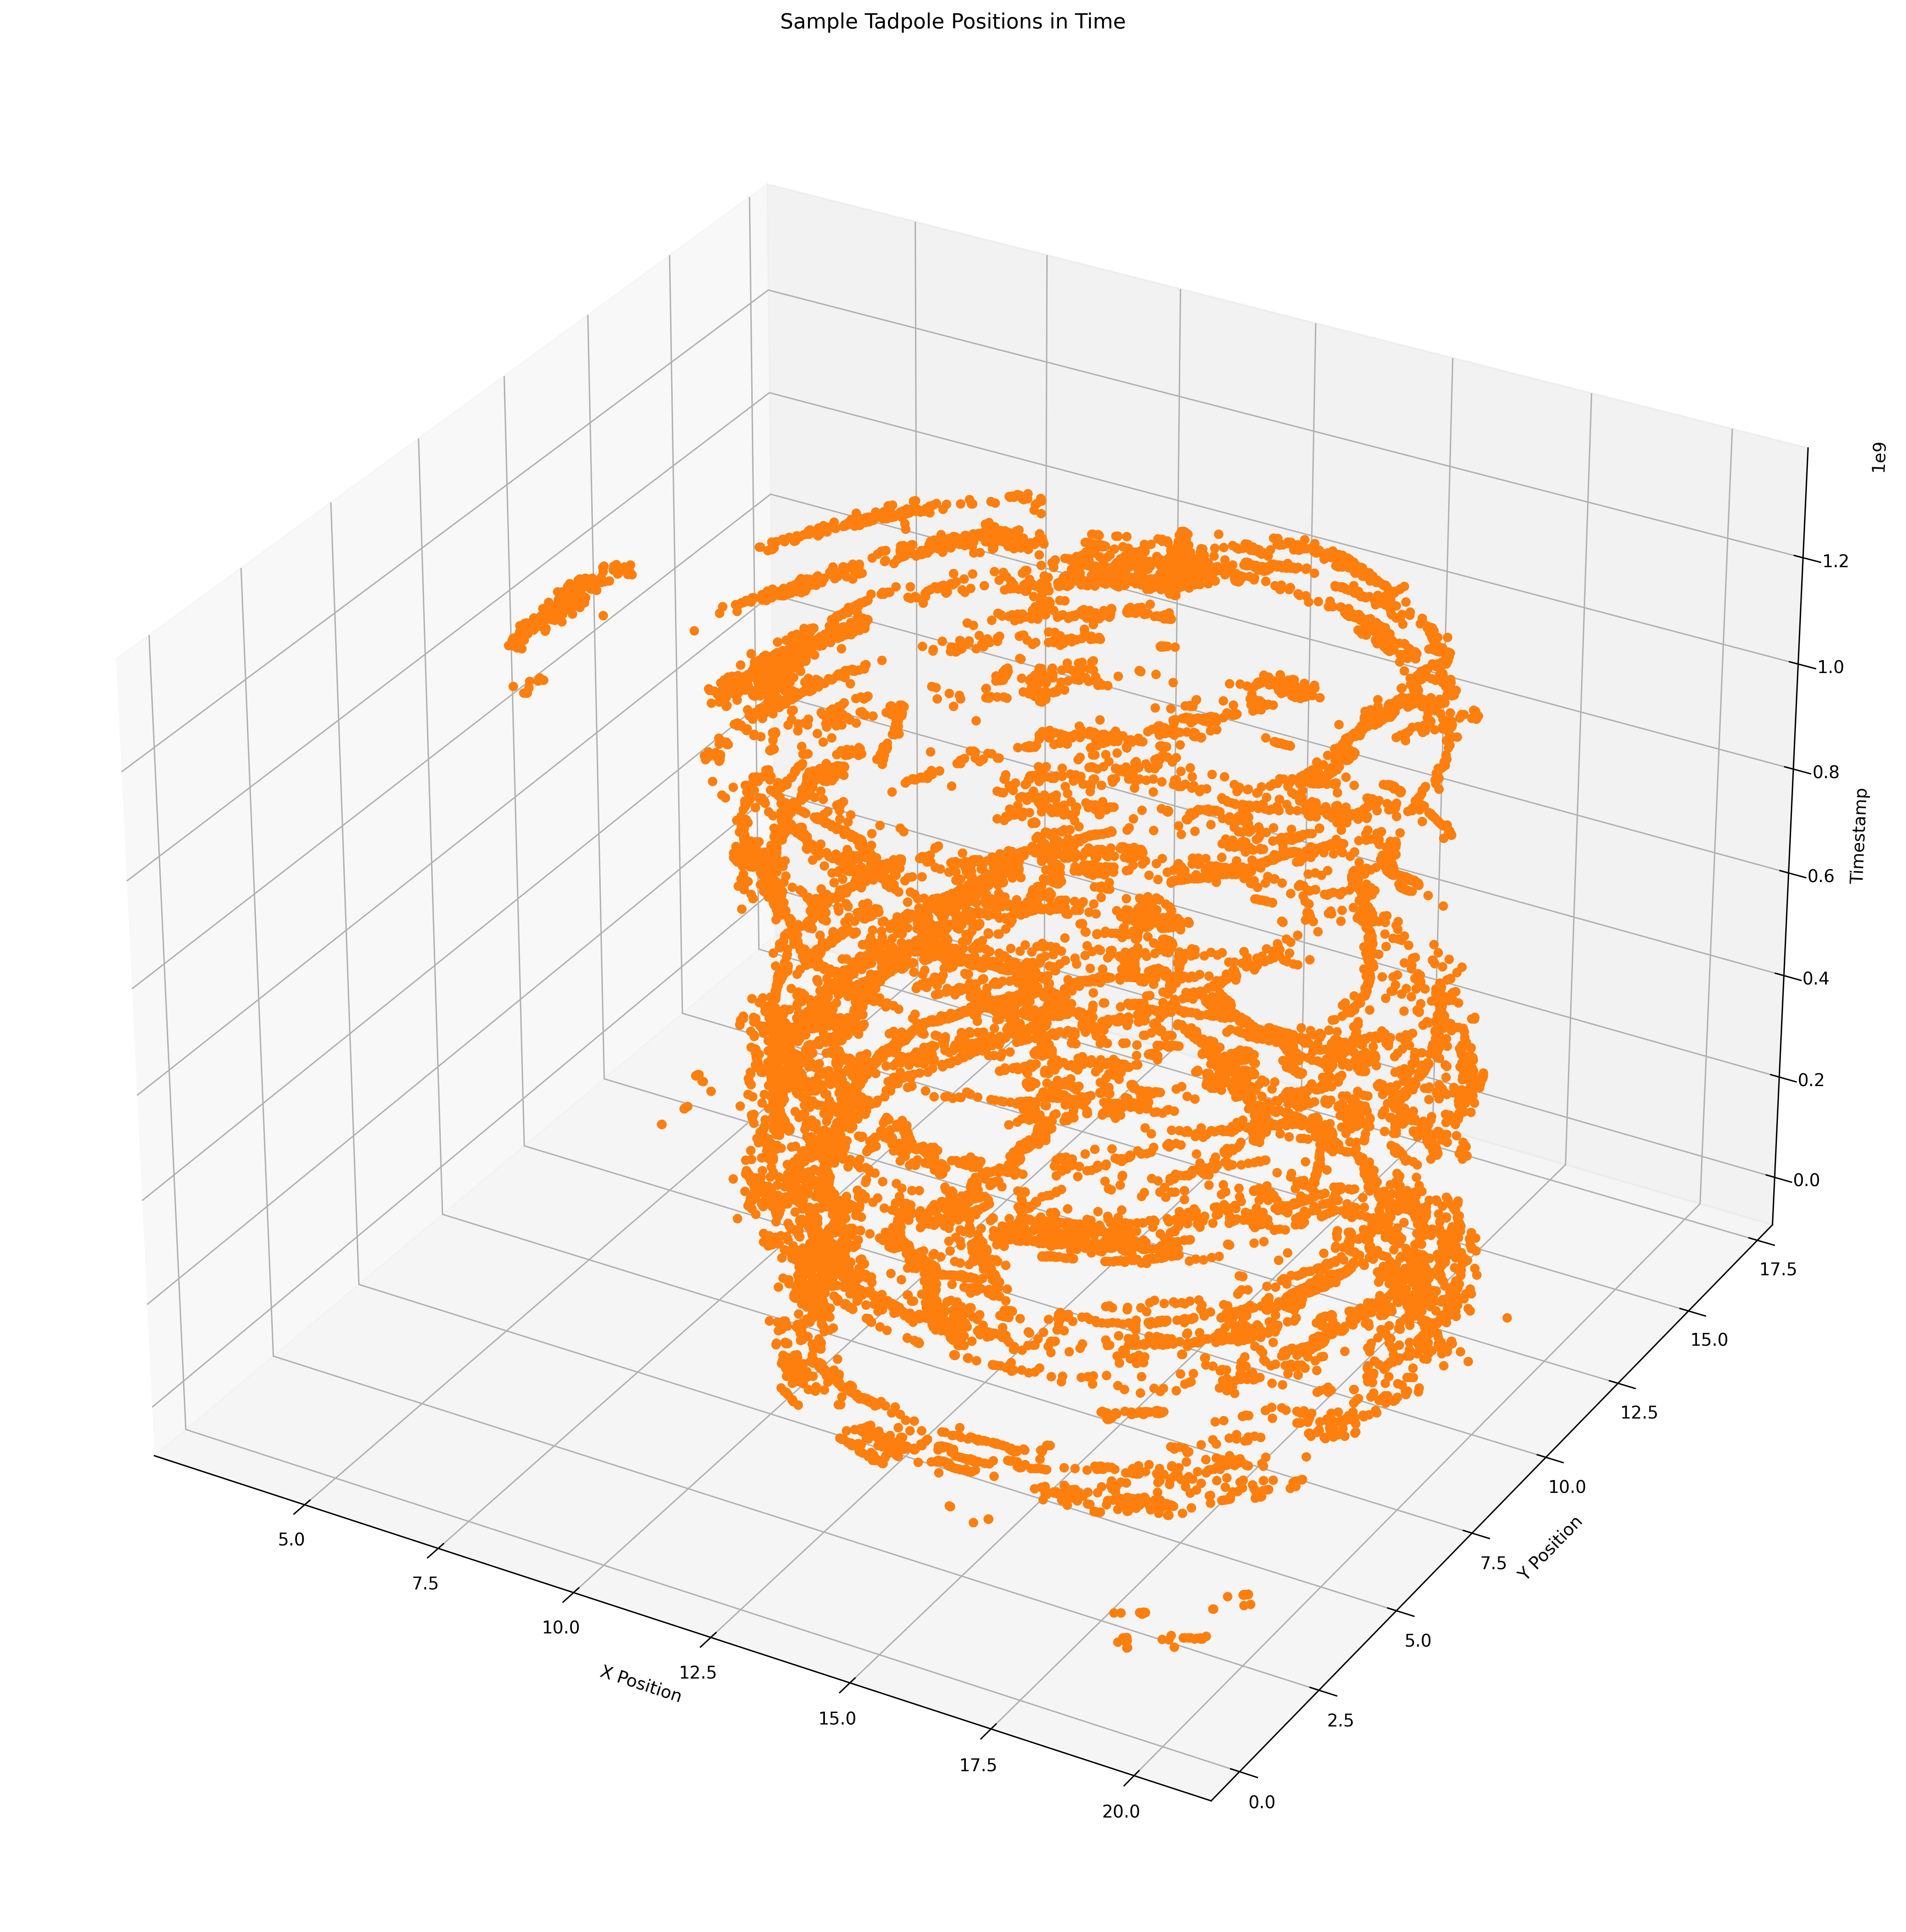

CPU times: user 3min 58s, sys: 931 ms, total: 3min 59s
Wall time: 3min 59s


In [17]:
%%time
# Build figure
fig = plt.figure(figsize=(20, 20), dpi=320)
ax = fig.add_subplot(projection='3d')

# Plot coordinates for tadpole
for record in sample_position_df.iterrows():
    xs = record[1]['X']
    ys = record[1]['Y']
    zs = record[1]['timestamp']
    ax.scatter(xs, ys, zs, marker='o', c='#ff7f0e')

# Add labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Timestamp')

# Add title
plt.title('Sample Tadpole Positions in Time')

# Display
plt.show()

### Plot Coordinates in Time for Multiple Sample Tadpoles for Non-Missing Frames
Here we take a sample of four tadpoles to keep the graph from getting too messy.  Skip this cell if you don't want to wait.  Plotting all coordinates is slow.

In [18]:
%%time
# Build figure
fig = plt.figure(figsize=(20, 20), dpi=320)
ax = fig.add_subplot(projection='3d')

# Iterate through sample tadpoles and colors
names = []
colors = ['#FFC733', '#90FF33', '#BE33FF', '#FF33DD']
for tadpole_file, color in zip(all_tadpole_data_files[0:4], colors):
    
    # Retrieve tadpole name from file
    tadpole_name = 'Tadpole ' + tadpole_file.split('/')[-1].split('tadpole')[-1].split('.')[0]
    names.append(tadpole_name)
    
    # Load tadpole data
    tadpole_data = np.load(tadpole_file)
    
    # Create tadpole dataframe
    tadpole_df = pd.DataFrame({
        'timestamp': tadpole_data['timestamp'],
        'X': tadpole_data['X'],
        'Y': tadpole_data['Y']
    })
    
    # Plot coordinates for tadpole
    for record in tadpole_df.iterrows():
        xs = record[1]['X']
        ys = record[1]['Y']
        zs = record[1]['timestamp']
        ax.scatter(xs, ys, zs, marker='o', c=color)

# Add labels
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Timestamp')

# Add legend
patches = [mpatches.Patch(color=c, label=n) for c, n in zip(colors, names)]
plt.legend(handles=patches)

# Add title
plt.title('Sample Tadpole Positions in Time')

# Display
plt.show()

CPU times: user 19min 15s, sys: 6.21 s, total: 19min 21s
Wall time: 19min 25s


### Create Dataframe of Locations of All Tadpoles

In [19]:
%%time
tadpole_names = []
last_tadpole_name = None
global_df = pd.DataFrame()
for i, tadpole_file in enumerate(all_tadpole_data_files):
    
    # Retrieve tadpole name from file
    tadpole_name = tadpole_file.split('/')[-1].split('tadpole')[-1].split('.')[0]
    tadpole_names.append(tadpole_name)

    # Load tadpole data
    tadpole_data = np.load(tadpole_file) 
    
    # Create tadpole dataframe
    tadpole_df = pd.DataFrame({
        f'{tadpole_name}_timestamp': tadpole_data['timestamp'],
        f'{tadpole_name}_X': tadpole_data['X'],
        f'{tadpole_name}_Y': tadpole_data['Y']
    })
    
    # Add each individual tadpole dataframe to the global dataframe
    if i == 0:
        global_df = tadpole_df
        last_tadpole_name = tadpole_name
    else:
        global_df = pd.merge(
            global_df,
            tadpole_df,
            left_on=f'{last_tadpole_name}_timestamp',
            right_on=f'{tadpole_name}_timestamp',
            how='left'
        )
        last_tadpole_name = tadpole_name

CPU times: user 648 ms, sys: 44.2 ms, total: 692 ms
Wall time: 1.27 s


### Remove Missing Timestamps and Sync Timestamp Columns
In the following blocks we drop frames where timestamps are missing for at least one tadpole.  Note that this constitutes a very small number of frames. We also check that the timestamps in the global dataframe, after dropping missing timestamps, can be safely merged to a single, global timestamp column and run this transformation.

In [20]:
global_df.shape

(37949, 90)

In [21]:
for tadpole in tadpole_names:
    global_df = global_df[global_df[f'{tadpole_name}_timestamp'].notna()]

In [23]:
equal_timestamps = []
for i in range(len(tadpole_names) - 1):
    equal_timestamps.append(np.all(global_df[f'{tadpole_names[i]}_timestamp'] == global_df[f'{tadpole_names[i + 1]}_timestamp']))

In [24]:
np.all(equal_timestamps)

True

In [25]:
global_df['timestamp'] = global_df[f'{random.choice(tadpole_names)}_timestamp']

In [26]:
for tadpole_name in tadpole_names:
    global_df = global_df.drop(f'{tadpole_name}_timestamp', axis=1)

In [27]:
global_df.shape

(37935, 61)

### View Sample of All Tadpole Data

In [28]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(global_df.sample(n=10))

12_X       12_Y       13_X       13_Y       11_X       11_Y  \
20066  10.624742   7.669088  13.483212  10.352904  13.781834  11.026503   
14102        inf        inf        inf        inf        inf        inf   
22287  16.047920  13.654263  12.399363   3.268053  17.233721   4.131246   
14248  17.267080  10.615110   8.159105   9.641563        inf        inf   
22137  15.312876  13.946078  15.775763   5.520234  18.230259   7.069032   
6305   17.995811  11.992507  16.107096   9.913468   0.132306  10.028975   
35175   7.609396   9.798433  14.613972  13.764212  16.230125  12.479315   
16223   9.190485   9.374155  10.927135   6.471198  14.402935  11.577875   
16262   9.415754   9.271470  10.921344   6.357013  14.460317  11.531994   
16410   9.606343  10.121394  10.972996   6.491702  14.628705  11.546522   

            10_X       10_Y        9_X        9_Y       28_X       28_Y  \
20066  10.201046   8.884658  18.342812  11.694713   9.133408   8.997896   
14102  18.515295   6.461005  18.104210  13.696916        inf        inf   
22287  14.388425   3.641178  15.405468   6.783805  17.768486   5.197127   
14248  18.289103   5.546060  18.362598  11.777266  15.746336   4.041201   
22137  18.476820   6.402528  15.963996   7.517381  17.825197   8.734001   
6305         inf        inf  10.418272  13.537773  18.216597   6.482480   
35175  13.072083  12.749714  19.753523   8.088929  18.198500  11.896765   
16223        inf        inf  20.088491   1.562346  12.428517  10.947581   
16262  17.908878   4.691874  20.066128   1.547282  12.424258  10.924929   
16410  10.325017   4.481853  15.092440   3.263773        inf        inf   

            14_X       14_Y       15_X      15_Y       29_X       29_Y  \
20066  15.490013   9.997084  18.021221  8.137913  12.946120  11.758542   
14102  10.371979   7.128788  14.205224  9.695206   9.712801  16.703562   
22287  15.689127   3.955543        inf       inf  12.212434   4.223699   
14248  10.390307   8.946220  14.063903  9.601700  12.475639  10.961110   
22137        inf        inf        inf       inf  15.161639   3.540045   
6305   16.155294   3.797852   9.056338  7.718919  11.691152   9.239715   
35175  26.265642  15.419545  14.626410  5.981779  15.719073   3.967611   
16223  18.710302   6.733456  14.068581  9.602156  16.086044   4.147892   
16262        inf        inf  14.095271  9.598173  13.417224   3.743067   
16410  12.628683   3.841394  14.108669  9.576897   8.923772   7.527968   

             8_X        8_Y       17_X       17_Y       16_X       16_Y  \
20066  12.180449   9.630342        inf        inf  15.832164   8.380032   
14102  17.881952   5.336390   9.162376   9.832903   8.595126   8.691145   
22287  14.639589   9.013054  16.405518   7.886501  10.698179  12.374084   
14248  13.414313   3.610186   9.063532   7.947346   8.271587  11.500281   
22137  16.587070   4.589091  15.815491   3.154025        inf        inf   
6305   16.424171   5.986555        inf        inf  14.965773  13.922200   
35175  17.594151   4.341729  11.721268  10.661698  12.610291   5.695332   
16223  16.188877  11.581592        inf        inf  14.598077   3.263114   
16262  16.246117  11.282151  15.612087   3.919745  13.814556   2.960895   
16410  16.516384  10.404192  11.795626   4.075913        inf        inf   

             6_X        6_Y       27_X       27_Y       26_X       26_Y  \
20066  10.868323  11.264368  12.384505   8.971334   8.776295   7.964634   
14102  11.993925   4.023612   9.748380  11.814230  18.197664  12.058251   
22287  16.710960   4.669177  18.209002  11.815504  14.337956   4.146544   
14248  10.546652   4.667088        inf        inf        inf        inf   
22137  16.690908   4.836264  17.113104  12.952998  17.380331   5.636257   
6305   11.565202  11.109127   9.760199  16.734993   7.575966   9.650681   
35175  15.883439   3.710607  18.418520   9.010872  15.946888   3.535805   
16223  19.117367  10.703827        inf        inf  12.886150   3.962504   
16262        inf        inf        inf      

### Create Tadpole Position Nested Dictionary for Collision Analysis
Keys are tadpoles and values are dictionaries containing X and Y positions for each timestamp from the global dataframe.

In [29]:
# Build empty dict
tadpole2position = {}

# Iterate through dataframe columns ignoring the 0th index which is the timestamp
records = global_df.columns[1:]
for i in range(0, len(records), 3):
    
    # Retrieve name and x, y positions
    tadpole_name = records[i].split('_')[0]
    x = global_df[f'{tadpole_name}_X'].values
    y = global_df[f'{tadpole_name}_Y'].values
    
    # Create dict entry
    tadpole2position[tadpole_name] = {'X': tadpole_data['X'], 'Y': tadpole_data['Y']}

### Define Function to Determine if Two Positions Constitute a Collision
Consider other ways to handle inf values.

In [30]:
def is_collision(a, b):
    """
    Return True if coordiantes a and b represent a collision,
    otherise return False.
    """
    
    # If one coordinate contains an infinite value
    # don't count this coordinate pair as a collision
    if np.inf in a or np.inf in b:
        return False
    
    # Compute L2 norm (euclidean distance)
    dist = np.linalg.norm(a-b, ord=2)
    if dist < COLLISION_THRESHOLD:
        return True
    else:
        return False

### Define Function to Compare All Tadpole Positions at a Given Frame to Find Collisions

In [31]:
@ray.remote
def compare_positions_at_frame(frame_idx):
    """
    For a given frame index, compare the position of each tadpole
    to every other tadpole: O(n^2).  Return a list of sets of tadpoles
    which represent the collisions for the frame.
    """
    
    # Track collisions
    collisions = []
    
    # Iterate through tadpoles
    for tadpole_i, data_i in tadpole2position.items():
        
        # Create position vector i
        x_i = data_i['X'][frame_idx]
        y_i = data_i['Y'][frame_idx]
        position_i = np.array([x_i, y_i])
        
        # Compare to every other tadpole
        for tadpole_j, data_j in tadpole2position.items():
            
            # Skip comparing to oneself
            if tadpole_i == tadpole_j:
                continue
            
            # Use a set to represent tadpole pairs
            # so that the order of tadpoles i and j doesn't matter
            pair = set((tadpole_i, tadpole_j))
            
            # If we have already run is_collision for this pair,
            # skip to the next pair
            if pair in collisions:
                continue
            
            # Create position vector j
            x_j = data_i['X'][frame_idx]
            y_j = data_i['Y'][frame_idx]
            position_j = np.array([x_j, y_j])
            
            # Check if this is a collision
            if is_collision(position_i, position_j):
                
                # Save the pair that collided
                collisions.append(pair)
                
    return collisions

### Run Parallel Comparisons for All Frames
Ray uses multi-processing to apply the `compare_records` functions to many frames at once.

In [32]:
ray.init()

/opt/anaconda3/lib/python3.8/site-packages/ray/_private/services.py:238: UserWarning: Not all Ray Dashboard dependencies were found. To use the dashboard please install Ray using `pip install ray[default]`. To disable this message, set RAY_DISABLE_IMPORT_WARNING env var to '1'.
  warnings.warn(warning_message)


{'node_ip_address': '192.168.1.109',
 'raylet_ip_address': '192.168.1.109',
 'redis_address': '192.168.1.109:6379',
 'object_store_address': '/tmp/ray/session_2021-09-27_17-49-53_676719_42030/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-09-27_17-49-53_676719_42030/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2021-09-27_17-49-53_676719_42030',
 'metrics_export_port': 64528,
 'node_id': '8eb1f63197fb2870fdf714ab317508bf4c2794d0baa08cb9a6227317'}

In [33]:
timestamps = global_df['timestamp'].values

In [34]:
%%time
all_collisions = ray.get([compare_positions_at_frame.remote(frame_idx) for frame_idx in range(len(timestamps))])

CPU times: user 24.7 s, sys: 5.44 s, total: 30.2 s
Wall time: 52.5 s


### Create Collisions Dataframe
To check for pairwise collisions at a given frame, index all_collisions for the frame and view the pairs that collided.

In [35]:
collision_df = pd.DataFrame({
    'timestamp': timestamps,
    'collisions': all_collisions
})

### View Sample Collisions

In [36]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(collision_df.sample(n=10))

timestamp                                         collisions
25471  8.783103e+08                                                 []
27534  9.494483e+08                                                 []
18009  6.210000e+08  [{12, 11}, {10, 12}, {28, 12}, {12, 14}, {12, ...
36359  1.253759e+09                                                 []
18726  6.457242e+08                                                 []
250    8.620689e+06  [{12, 11}, {12, 10}, {28, 12}, {12, 14}, {12, ...
25529  8.803103e+08                                                 []
32698  1.127517e+09  [{12, 11}, {12, 10}, {12, 28}, {12, 14}, {12, ...
23173  7.990690e+08  [{12, 11}, {12, 10}, {12, 28}, {12, 14}, {12, ...
5869   2.023793e+08  [{12, 11}, {12, 10}, {28, 12}, {12, 14}, {12, ...

### Create Timestamp for Saving Records

In [37]:
timestr = time.strftime("%Y%m%d-%H%M%S")

### Save Tadpole Location Dataframe

In [42]:
if not os.path.exists('datasets'):
    os.makedirs('datasets')

In [43]:
global_df.to_csv(f'datasets/tadpole_locations_{timestr}.csv', index=False)

### Save Pairwise Collision Dataframe

In [44]:
collision_df.to_csv(f'datasets/pairwise_tadpole_collisions_{timestr}.csv', index=False)